# SynFerm Exploratory Data Analysis
#### Targets:
- See some of the basic trends in the data (which BBs react well? which not at all?)
- perform basic statistics (How many successful reactions?)

#### Sections:
1. [Load and filter data](#1)
2. [Investigate "invalid" reactions](#2)
3. [General Statistics](#3)
4. [Building Block Statistics](#4)
5. [Trends within builing block classes](#5)
6. [Trends within builing block classes, corrected for monomers performance](#6)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath('../..'))

from definitions import DB_PATH
from src.db_retrieval.db_queries import MyDatabaseConnection

### Load and filter data <a id='section_id'></a>

In [2]:
from copy import deepcopy
import sqlite3

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100  # this makes the figures bigger in jupyter nb

In [3]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [4]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 52904


/var/folders/bw/f4bnnf4n0c94qdgp8y3gvxsc0000gn/T/ipykernel_50472/3129990183.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})


### Select experiments for analysis

In [5]:
# show all available experiments with reaction counts
df_full["exp_nr"].value_counts().sort_index()

1        1920
2        1920
3        1920
4        1920
5        1920
6        1920
7        1920
8        1920
9        1920
10       1920
11       1920
12       1920
13       1920
14       1920
15       1920
16       1920
17       1920
18       1920
19       1920
20       1920
21       1920
22       1920
23       1920
24       1920
25       1920
26       1920
99000     384
99001     648
99002     592
99003      16
99004     384
99005     960
Name: exp_nr, dtype: int64

In [6]:
# select experiment numbers for further analysis
start_exp_nr = 4
end_exp_nr = 24  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  # kick out invalid experiments (SOP changed after exp3)
print(f'Number of reactions since SOP change and without test reactions: {len(df_full)}')

Number of reactions since SOP change and without test reactions: 40320


### Investigate "invalid" reactions <a id=2></a>

In [7]:
# how many reactions might be invalid?
df_full.loc[:,'valid'].value_counts().head(10)

heating failure                                                                  1920
ERROR: too many peaks for IS (2); WARNING: IS response differs >50% from mean    1084
ERROR: too many peaks for IS (2)                                                  549
too many peaks for product A (2)                                                  525
too many peaks for product A (3)                                                  237
ERROR: too many peaks for product A (5)                                           208
ERROR: I/M transfer error                                                         176
Name: valid, dtype: int64

In [ ]:
# let's see these invalid reactions
df_full.loc[df_full['valid'] == 'too many peaks for product A (4)']

Let's have a look at the worst offenders. there might be a structural reason why they give multiple peaks in LCMS

In [ ]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (2)', ['initiator']].value_counts()
x

In [ ]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [ ]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (4)', ['monomer']].value_counts()
x

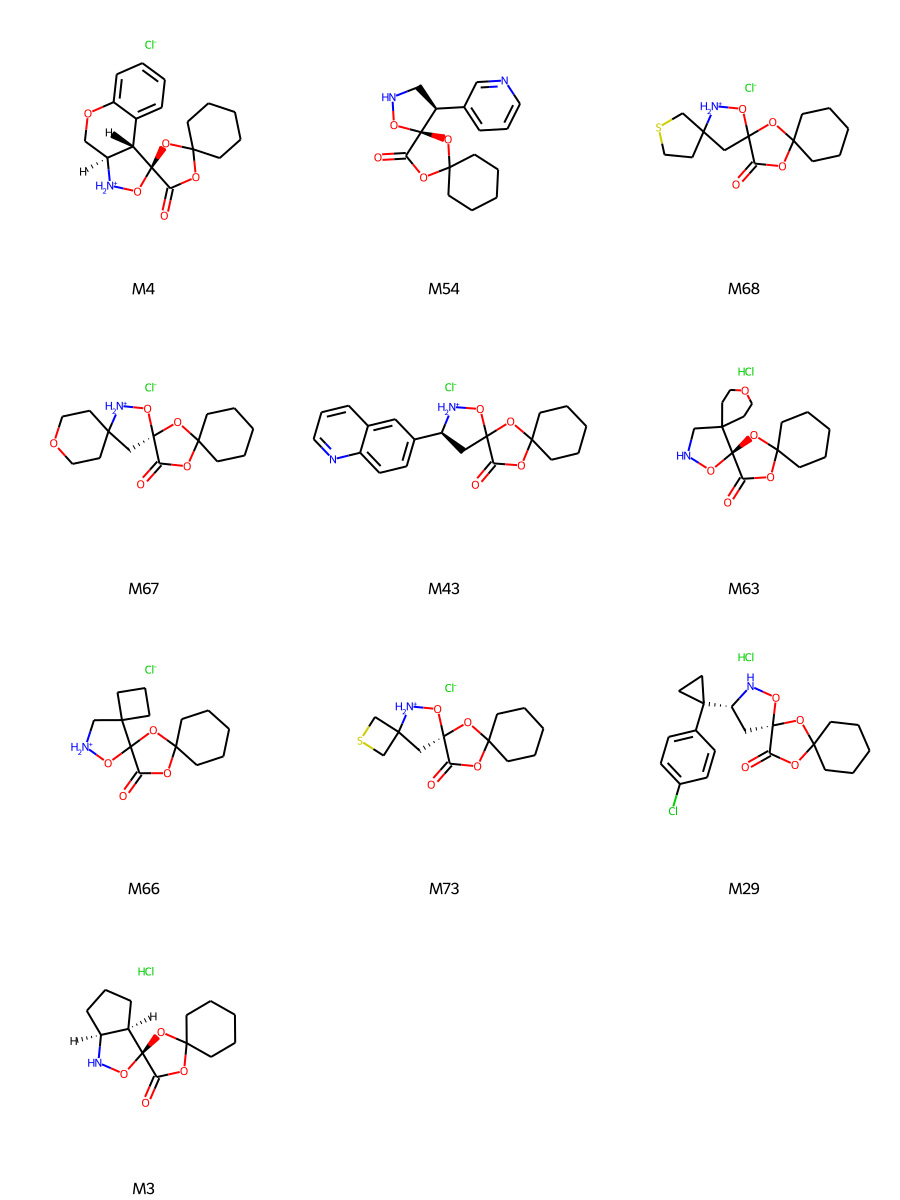

In [13]:
# let's look at these molecules
mols = []
for bb in x.head(10).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [14]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (4)', ['terminator']].value_counts()
x

terminator
T20           8
T21           8
T28           8
T1            7
T40           7
T22           6
T30           6
T36           6
T34           4
T39           4
T3            3
T32           3
T7            3
T13           2
T17           2
T31           2
dtype: int64

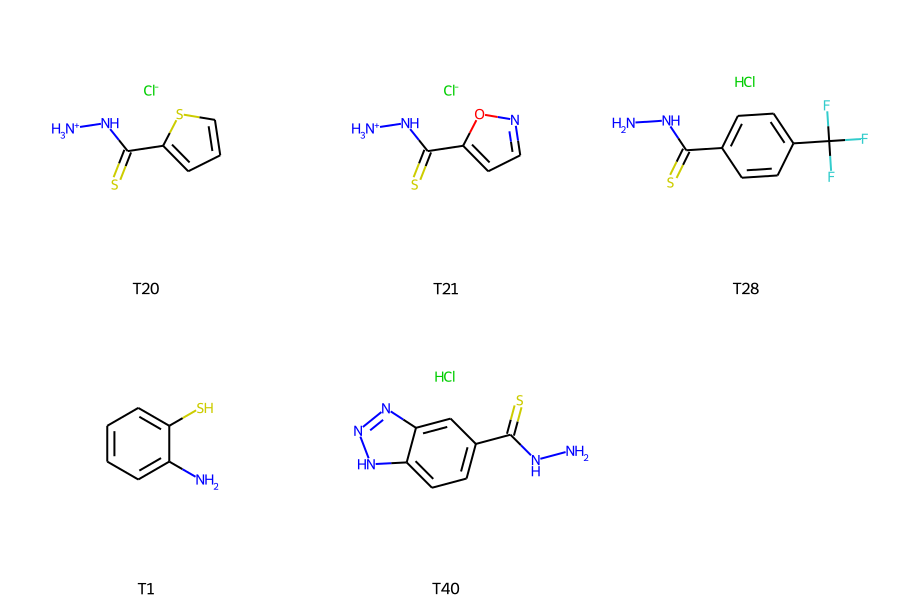

In [15]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

#### Remove invalid reactions
It seems reasonable to assume that up to 4 peaks for A could be from diasteromers + regioisomers so we will accept anything that has 4 or less peaks for A into our cleaned data set

In [8]:
df = df_full.loc[df_full['valid'].isna() 
                 | (df_full['valid'] == 'heating failure') 
                 | (df_full['valid'] == 'too many peaks for product A (2)') 
                 | (df_full['valid'] == 'too many peaks for product A (3)')
                 | (df_full['valid'] == 'too many peaks for product A (4)')
                ] 
print(f'Number of reactions after removing invalid entries: {len(df)}')

Number of reactions after removing invalid entries: 29415


In [9]:
df = df.loc[~df['product_A_lcms_ratio'].isna()]  # remove all entries where product A is NaN (these are the entries not yet measured)
print(f'Number of reactions after removing NaN entries: {len(df)}')

Number of reactions after removing NaN entries: 25575


In [10]:
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-16 22:00:00,I67,M2,T25,Ph023,Fused005,...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(C=C...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C1(C(=O)O...,O=C(OCc1ccccc1)N1C[C@@H]2NC(c3ccc(Cl)cc3)=[N+]...,Clc1ccc(-c2nnc(C=Cc3ccccc3)s2)cc1,C(=Cc1nnc(C=Cc2ccccc2)s1)c1ccccc1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,O=C(OCc1ccccc1)N1CC=C(c2nnc(C=Cc3ccccc3)s2)C1,200310,heating failure
9619,5,2,A4,JG253,2021-08-16 22:00:00,I67,M2,T39,Ph023,Fused005,...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(-c2...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C1(C(=O)O...,O=C(OCc1ccccc1)N1C[C@@H]2NC(c3ccc(Cl)cc3)=[N+]...,Clc1ccc(-c2nnc(-c3cn[nH]c3)s2)cc1,c1n[nH]cc1-c1nnc(-c2cn[nH]c2)s1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,O=C(OCc1ccccc1)N1CC=C(c2nnc(-c3cn[nH]c3)s2)C1,200324,heating failure
9620,5,2,A5,JG253,2021-08-16 22:00:00,I67,M2,T30,Ph023,Fused005,...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(-c2...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C1(C(=O)O...,O=C(OCc1ccccc1)N1C[C@@H]2NC(c3ccc(Cl)cc3)=[N+]...,Clc1ccc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)cc1,Clc1cc(Cl)cc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)c1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,O=C(OCc1ccccc1)N1CC=C(c2nnc(-c3cc(Cl)cc(Cl)c3)...,200315,heating failure
9621,5,2,A6,JG253,2021-08-16 22:00:00,I67,M2,T34,Ph023,Fused005,...,CN(C)c1cccc(-c2nnc([C@@H]3CN(C(=O)OCc4ccccc4)C...,CN(C)c1cccc(C2=NNC(C(=O)O)([C@@H]3CN(C(=O)OCc4...,CN(C)c1cccc(C2=N[N+]3=C(c4ccc(Cl)cc4)N[C@H]4CN...,CN(C)c1cccc(-c2nnc(-c3ccc(Cl)cc3)s2)c1,CN(C)c1cccc(-c2nnc(-c3cccc(N(C)C)c3)s2)c1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,CN(C)c1cccc(-c2nnc(C3=CCN(C(=O)OCc4ccccc4)C3)s...,200319,heating failure
9622,5,2,A7,JG253,2021-08-16 22:00:00,I67,M2,T17,Ph023,Fused005,...,CCOc1ccc2nc([C@@H]3CN(C(=O)OCc4ccccc4)C[C@@H]3...,CCOc1ccc2c(c1)SC(C(=O)O)([C@@H]1CN(C(=O)OCc3cc...,CCOc1ccc2c(c1)SC1(C(=O)[O-])[C@@H]3CN(C(=O)OCc...,CCOc1ccc2nc(-c3ccc(Cl)cc3)sc2c1,CCOc1ccc(N)c(SSc2cc(OCC)ccc2N)c1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,CCOc1ccc2nc(C3=CCN(C(=O)OCc4ccccc4)C3)sc2c1,200302,heating failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54792,22,3,P20,JG359,2022-07-13 00:00:00,I44,M53,T21,BiPh007,Mon099,...,O=C(O)c1ccc(C(=O)NC[C@@H](c2ccoc2)c2nnc(-c3ccn...,O=C(O)c1ccc(C(=O)NC[C@@H](c2ccoc2)C2(C(=O)O)NN...,O=C(O)c1ccc(C2=[N+]3N=C(c4ccno4)SC3(C(=O)[O-])...,O=C(O)c1ccc(-c2nnc(-c3ccno3)s2)cc1,c1cc(-c2nnc(-c3ccno3)s2)on1,O=C(O)C(=O)[C@@H](CNC(=O)c1ccc(C(=O)O)cc1)c1ccoc1,O=C(O)c1ccc(C(=O)NC[C@H](C(=O)O)c2ccoc2)cc1,C=C(c1ccoc1)c1nnc(-c2ccno2)s1,132615,None
54793,22,3,P21,JG359,2022-07-13 00:00:00,I44,M53,T13,BiPh007,Mon099,...,COc1ccc2nc([C@@H](CNC(=O)c3ccc(C(=O)O)cc3)c3cc...,COc1ccc2c(c1)SC(C(=O)O)([C@@H](CNC(=O)c1ccc(C(...,COc1ccc2c(c1)SC1(C(=O)[O-])[C@H](c3ccoc3)CNC(c...,COc1ccc2nc(-c3ccc(C(=O)O)cc3)sc2c1,COc1ccc(N)c(SSc2cc(OC)ccc2N)c1,O=C(O)C(=O)[C@@H](CNC(=O)c1ccc(C(=O)O)cc1)c1ccoc1,O=C(O)c1ccc(C(=O)NC[C@H](C(=O)O)c2ccoc2)cc1,C=C(c1ccoc1)c1nc2ccc(OC)cc2s1,132607,None
54794,22,3,P22,JG359,2022-07-13 00:00:00,I44,M53,T27,BiPh007,Mon099,...,O=C(O)c1ccc(C(=O)NC[C@@H](c2ccoc2)c2nnc(-c3ccc...,O=C(O)c1ccc(C(=O)NC[C@@H](c2ccoc2)C2(C(=O)O)NN...,O=C(O)c1ccc(C2=[N+]3N=C(c4ccc(O)cc4)SC3(C(=O)[...,O=C(O)c1ccc(-c2nnc(-c3ccc(O)cc3)s2)cc1,Oc1ccc(-c2nnc(-c3ccc(O)cc3)s2)cc1,O=C(O)C(=O)[C@@H](CNC(=O)c1ccc(C(=O)O)cc1)c1ccoc1,O=C(O)c1ccc(C(=O)NC[C@H](C(=O)O)c2ccoc2)cc1,C=C(c1ccoc1)c1nnc(-c2ccc(O)cc2)s1,132621,None


In [16]:
# due to bug 2022-08-12, we cannot consider plates 1-3 from earlier experiments until they are reprocessed
df = df.loc[~((df["exp_nr"] < 22) & (df["plate_nr"] < 4))]
len(df)

14358

Now we have a cleaned dataset. Let's try some basic statistics

How many reactions are successful (i.e. normalized lmcs ratio for A > threshold ?)

In [17]:
# first min-max normalize all the lcms columns seperately

df = deepcopy(df)
lcms_df = df[['product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio', 'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio', 'product_G_lcms_ratio', 'product_H_lcms_ratio']]
df[['A_normalized','B_normalized', 'C_normalized', 'D_normalized', 'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized']] = (lcms_df-lcms_df.min())/(lcms_df.max()-lcms_df.min())
df                                      

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,vl_id,valid,A_normalized,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-16 22:00:00,I67,M20,T25,Ph023,Mon017,...,201048,heating failure,0.239340,0.145169,0.004820,0.000000,0.012145,0.006604,0.059794,0.000622
10579,5,4,A4,JG255,2021-08-16 22:00:00,I67,M20,T39,Ph023,Mon017,...,201062,heating failure,0.037641,0.105225,0.004056,0.000000,0.001908,0.009637,0.062440,0.000000
10580,5,4,A5,JG255,2021-08-16 22:00:00,I67,M20,T30,Ph023,Mon017,...,201053,heating failure,0.091676,0.098541,0.000710,0.000000,0.000000,0.008287,0.061370,0.000000
10581,5,4,A6,JG255,2021-08-16 22:00:00,I67,M20,T34,Ph023,Mon017,...,201057,heating failure,0.210597,0.288984,0.001253,0.000107,0.008349,0.009118,0.072213,0.000457
10582,5,4,A7,JG255,2021-08-16 22:00:00,I67,M20,T17,Ph023,Mon017,...,201040,heating failure,0.070288,0.000000,0.000000,0.000000,0.000000,0.007924,0.607977,0.001297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54792,22,3,P20,JG359,2022-07-13 00:00:00,I44,M53,T21,BiPh007,Mon099,...,132615,None,0.000000,0.001036,0.000000,0.018395,0.000461,0.000073,0.000000,0.000000
54793,22,3,P21,JG359,2022-07-13 00:00:00,I44,M53,T13,BiPh007,Mon099,...,132607,None,0.000000,0.000000,0.000955,0.115837,0.000000,0.000092,0.000000,0.000251
54794,22,3,P22,JG359,2022-07-13 00:00:00,I44,M53,T27,BiPh007,Mon099,...,132621,None,0.000000,0.000000,0.000000,0.037847,0.021339,0.000100,0.000000,0.011140


In [18]:
# add information about reactant classes to df
def get_reaction_type_for_series(ser):
    new = []
    for i in ser:
        new.append(db.get_reactant_class(i))
    return pd.Series(data=new)
        
df[['initiator_type', 'monomer_type', 'terminator_type']] = df[['initiator', 'monomer', 'terminator']].apply(get_reaction_type_for_series, axis=1)
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-16 22:00:00,I67,M20,T25,Ph023,Mon017,...,0.145169,0.004820,0.000000,0.012145,0.006604,0.059794,0.000622,KAT_arom,Mon_sub_3,TerTH
10579,5,4,A4,JG255,2021-08-16 22:00:00,I67,M20,T39,Ph023,Mon017,...,0.105225,0.004056,0.000000,0.001908,0.009637,0.062440,0.000000,KAT_arom,Mon_sub_3,TerTH
10580,5,4,A5,JG255,2021-08-16 22:00:00,I67,M20,T30,Ph023,Mon017,...,0.098541,0.000710,0.000000,0.000000,0.008287,0.061370,0.000000,KAT_arom,Mon_sub_3,TerTH
10581,5,4,A6,JG255,2021-08-16 22:00:00,I67,M20,T34,Ph023,Mon017,...,0.288984,0.001253,0.000107,0.008349,0.009118,0.072213,0.000457,KAT_arom,Mon_sub_3,TerTH
10582,5,4,A7,JG255,2021-08-16 22:00:00,I67,M20,T17,Ph023,Mon017,...,0.000000,0.000000,0.000000,0.000000,0.007924,0.607977,0.001297,KAT_arom,Mon_sub_3,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54792,22,3,P20,JG359,2022-07-13 00:00:00,I44,M53,T21,BiPh007,Mon099,...,0.001036,0.000000,0.018395,0.000461,0.000073,0.000000,0.000000,KAT_arom,Mon_sub_2,TerTH
54793,22,3,P21,JG359,2022-07-13 00:00:00,I44,M53,T13,BiPh007,Mon099,...,0.000000,0.000955,0.115837,0.000000,0.000092,0.000000,0.000251,KAT_arom,Mon_sub_2,TerABT
54794,22,3,P22,JG359,2022-07-13 00:00:00,I44,M53,T27,BiPh007,Mon099,...,0.000000,0.000000,0.037847,0.021339,0.000100,0.000000,0.011140,KAT_arom,Mon_sub_2,TerTH


### General Statistics <a id=3></a>

Let's look at how well reactions have worked across the (cleaned) data set

In [19]:
for threshold in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    t_and_f = (df['A_normalized'] >= threshold).value_counts()
    print(f'This ratio of reactions is above the {threshold:.1%} threshold: {t_and_f[True] / (t_and_f[True]+ t_and_f[False]):.1%}')

This ratio of reactions is above the 0.1% threshold: 63.0%
This ratio of reactions is above the 0.5% threshold: 48.4%
This ratio of reactions is above the 1.0% threshold: 40.8%
This ratio of reactions is above the 5.0% threshold: 20.9%
This ratio of reactions is above the 10.0% threshold: 11.2%
This ratio of reactions is above the 20.0% threshold: 4.0%


For a graphical assessment, we plot the histogramms for all normalized product yields

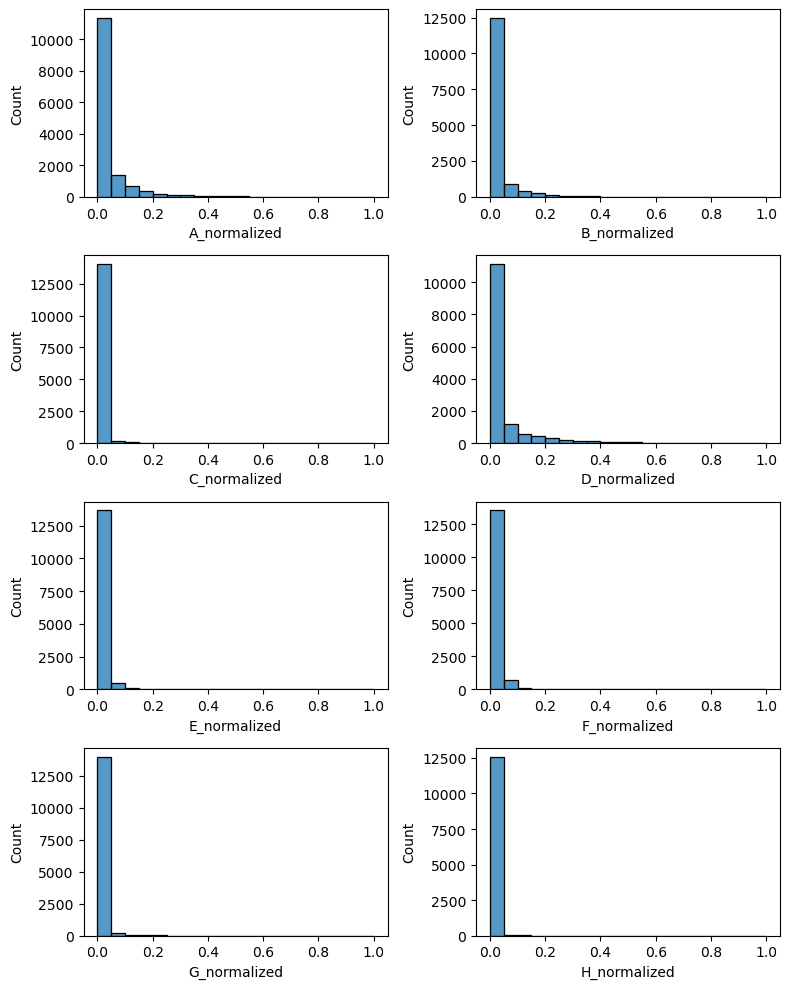

In [20]:
nbins = 20
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8,10))
sns.histplot(df['A_normalized'], bins=nbins, ax=axs[0][0])
sns.histplot(df['B_normalized'], bins=nbins, ax=axs[0][1])
sns.histplot(df['C_normalized'], bins=nbins, ax=axs[1][0])
sns.histplot(df['D_normalized'], bins=nbins, ax=axs[1][1])
sns.histplot(df['E_normalized'], bins=nbins, ax=axs[2][0])
sns.histplot(df['F_normalized'], bins=nbins, ax=axs[2][1])
sns.histplot(df['G_normalized'], bins=nbins, ax=axs[3][0])
sns.histplot(df['H_normalized'], bins=nbins, ax=axs[3][1])
plt.tight_layout()
plt.show()

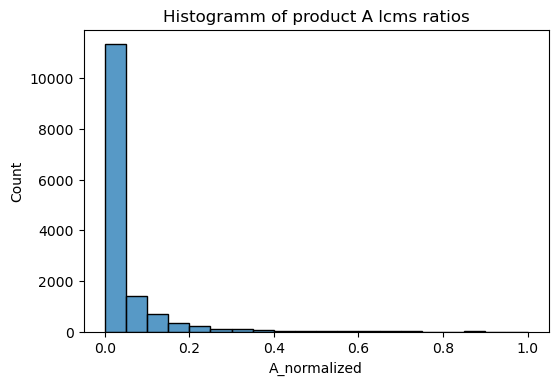

In [21]:
plt.figure()
sns.histplot(df['A_normalized'], bins=20)
plt.title('Histogramm of product A lcms ratios')
plt.show()

<Figure size 600x400 with 0 Axes>

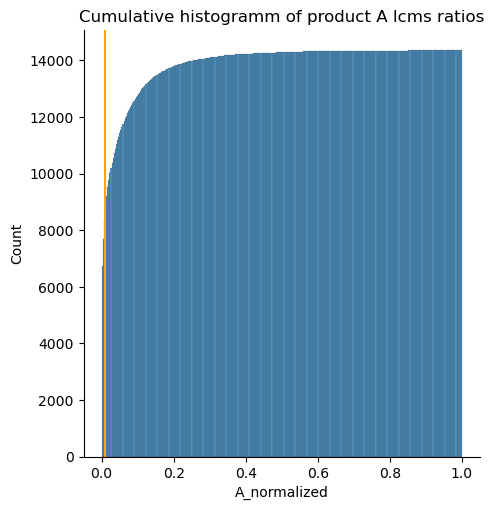

In [22]:
# let's see the same as a cumulative histogramm
plt.figure()
sns.displot(df['A_normalized'], cumulative=True)
plt.title('Cumulative histogramm of product A lcms ratios')
plt.axvline(x=0.01, color='orange')
plt.show()

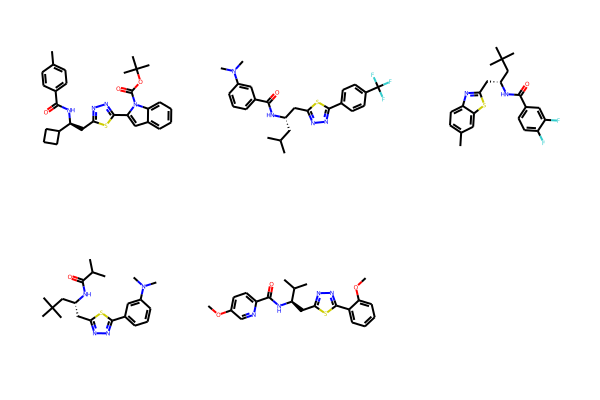

In [24]:
# What products have the highest "yields"?
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule, GenerateDepictionMatching3DStructure, Draw
products = []
for vl_id in df.sort_values('A_normalized', ascending=False).head(5)['vl_id']:
    products.append(db.get_vl_member(vl_id))
[Compute2DCoords(p) for p in products]
Draw.MolsToGridImage(products)

In [25]:
# let's check the highest "yielding" reaction
df.sort_values('A_normalized', ascending=False).head(1)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
36287,15,6,C15,JG320,2022-04-26,I76,M45,T26,Ph034,Mon091,...,0.122021,0.010496,0.000201,0.012861,0.015595,0.01239,0.000108,KAT_arom,Mon_sub_3,TerTH


### Building Block statistics <a id=4></a>

Let's look into details: __For each initator, how many reactions have worked above the threshold?__

In [26]:
THRESHOLD = 0.01

In [27]:
def calc_success_rate(df, column, threshold, sort_results=True):
    """
    Take a dataframe df, where for one column of interest, for each unique identifier in that column, the frequency
    of successful reactions (as indicated by the threshold) is calculated.
    :param df: pandas.DataFrame
    :param column: Column by which to group, e.g. monomer or monomer_type
    :param threshold: float, threshold for success
    :return: pandas.DataFrame
    """
    success_rates = []
    for i in df[column].unique():
        df_i = df.loc[df[column] == i]
        n_all = len(df_i)
        n_success = len(df_i.loc[df['A_normalized'] >= threshold])
        success_rates.append([i, n_success, n_all, n_success/n_all])
    if sort_results is True:
        success_rates = sorted(success_rates, key=lambda x: int(x[0][1:]))
    return pd.DataFrame(success_rates, columns=[column, 'n_success', 'n_all', 'success_rate'])

In [28]:
# we calculate success rates for all initiators
success_rates_by_initiator = calc_success_rate(df, 'initiator', THRESHOLD)
for _, i in success_rates_by_initiator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for I2: 55.3% (63/114)
Success rate for I3: 57.6% (185/321)
Success rate for I4: 35.9% (90/251)
Success rate for I5: 52.2% (129/247)
Success rate for I6: 43.0% (114/265)
Success rate for I7: 68.3% (209/306)
Success rate for I8: 51.0% (76/149)
Success rate for I9: 54.1% (72/133)
Success rate for I10: 56.4% (194/344)
Success rate for I11: 39.0% (57/146)
Success rate for I12: 36.8% (89/242)
Success rate for I13: 46.1% (59/128)
Success rate for I14: 39.1% (90/230)
Success rate for I15: 44.1% (93/211)
Success rate for I17: 42.9% (140/326)
Success rate for I18: 0.3% (1/303)
Success rate for I19: 25.9% (42/162)
Success rate for I20: 28.6% (44/154)
Success rate for I21: 34.5% (38/110)
Success rate for I22: 35.8% (92/257)
Success rate for I23: 34.8% (49/141)
Success rate for I24: 44.7% (59/132)
Success rate for I25: 60.8% (239/393)
Success rate for I26: 41.7% (80/192)
Success rate for I27: 52.0% (91/175)
Success rate for I28: 16.1% (46/286)
Success rate for I29: 38.5% (99/257)
Succ

In [29]:
# let's do the same for monomers
success_rates_by_monomer = calc_success_rate(df, 'monomer', THRESHOLD)
for _, i in success_rates_by_monomer.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for M1: 15.1% (16/106)
Success rate for M2: 15.9% (13/82)
Success rate for M3: 4.1% (15/370)
Success rate for M4: 33.1% (108/326)
Success rate for M5: 70.0% (7/10)
Success rate for M6: 37.5% (120/320)
Success rate for M7: 20.6% (66/320)
Success rate for M10: 63.9% (413/646)
Success rate for M11: 46.9% (226/482)
Success rate for M12: 0.0% (0/175)
Success rate for M16: 62.4% (229/367)
Success rate for M17: 71.9% (169/235)
Success rate for M18: 66.8% (205/307)
Success rate for M19: 15.4% (14/91)
Success rate for M20: 75.9% (432/569)
Success rate for M21: 69.2% (191/276)
Success rate for M24: 82.5% (193/234)
Success rate for M27: 0.0% (0/282)
Success rate for M28: 61.4% (127/207)
Success rate for M29: 42.0% (185/441)
Success rate for M31: 22.3% (55/247)
Success rate for M32: 67.2% (234/348)
Success rate for M33: 73.0% (165/226)
Success rate for M34: 70.4% (455/646)
Success rate for M35: 52.6% (120/228)
Success rate for M39: 0.6% (1/158)
Success rate for M40: 50.5% (54/107)
Suc

In [30]:
# and the same for terminators
success_rates_by_terminator = calc_success_rate(df, 'terminator', THRESHOLD)
for _, i in success_rates_by_terminator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for T1: 41.7% (190/456)
Success rate for T2: 34.7% (108/311)
Success rate for T3: 56.5% (292/517)
Success rate for T4: 57.3% (238/415)
Success rate for T5: 7.1% (23/324)
Success rate for T6: 8.3% (35/421)
Success rate for T7: 51.1% (272/532)
Success rate for T8: 9.3% (45/485)
Success rate for T9: 0.0% (0/196)
Success rate for T10: 10.2% (41/401)
Success rate for T11: 7.7% (24/311)
Success rate for T12: 34.8% (109/313)
Success rate for T13: 49.0% (272/555)
Success rate for T14: 58.0% (251/433)
Success rate for T15: 16.3% (68/417)
Success rate for T16: 10.0% (16/160)
Success rate for T17: 44.8% (204/455)
Success rate for T18: 1.8% (9/498)
Success rate for T19: 57.1% (133/233)
Success rate for T20: 60.1% (193/321)
Success rate for T21: 26.6% (85/319)
Success rate for T22: 62.5% (222/355)
Success rate for T23: 52.7% (128/243)
Success rate for T24: 62.3% (218/350)
Success rate for T25: 22.1% (95/429)
Success rate for T26: 59.4% (151/254)
Success rate for T27: 62.2% (237/381)
Su

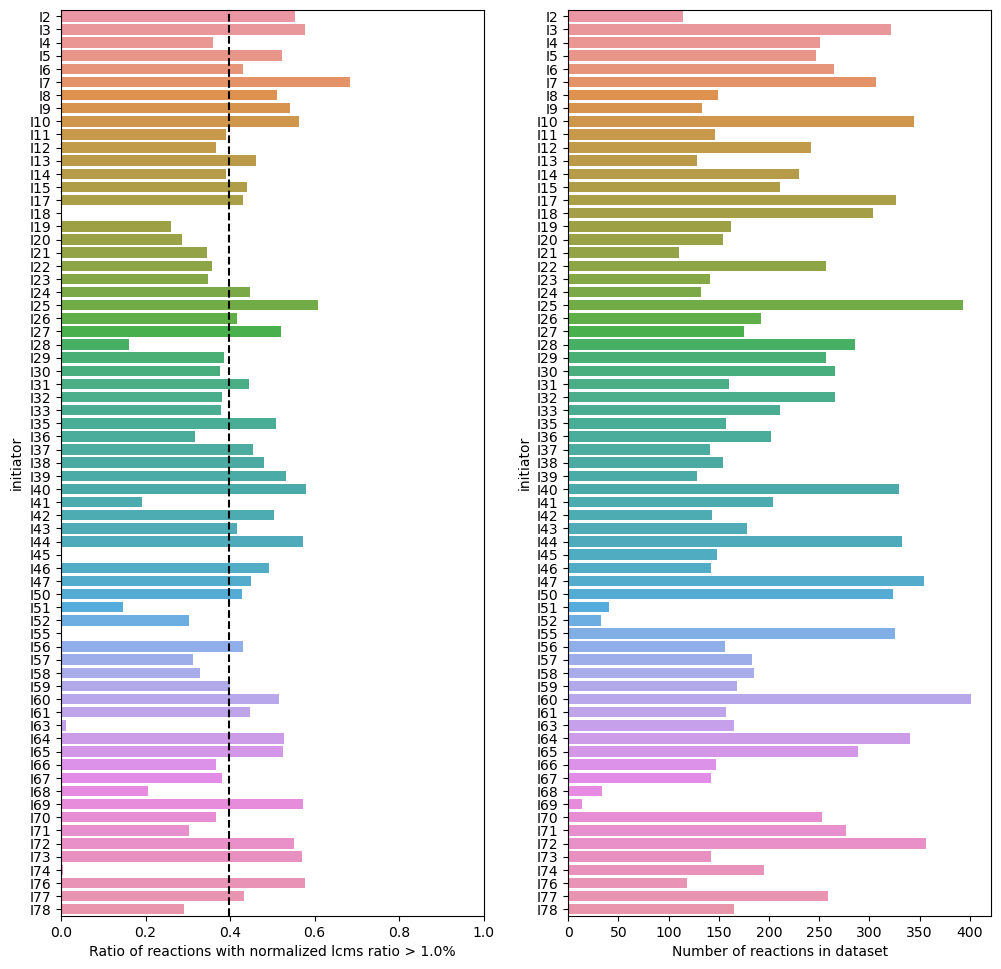

In [31]:
# show how many reactions are successful for each initiator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

axs[0].axvline(success_rates_by_initiator['success_rate'].mean(), ls='--', c='black')  # draw a mean line
sns.barplot(x=success_rates_by_initiator['success_rate'], y=success_rates_by_initiator['initiator'], ax=axs[0])
sns.barplot(x=success_rates_by_initiator['n_all'], y=success_rates_by_initiator['initiator'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

In [91]:
db.get_smiles("T18")

'Cc1cccc(S)c1N'

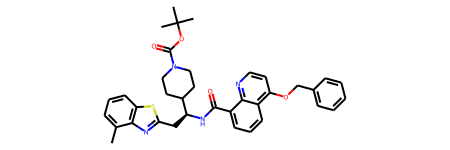

In [96]:
db.get_vl_member(65085)

In [51]:
df.columns

Index(['exp_nr', 'plate_nr', 'well', 'lab_journal_number',
       'synthesis_date_unixepoch', 'initiator', 'monomer', 'terminator',
       'initiator_long', 'monomer_long', 'terminator_long', 'long_name',
       'product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio',
       'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio',
       'product_G_lcms_ratio', 'product_H_lcms_ratio', 'comment',
       'product_A_smiles', 'product_B_smiles', 'product_C_smiles',
       'product_D_smiles', 'product_E_smiles', 'product_F_smiles',
       'product_G_smiles', 'product_H_smiles', 'vl_id', 'valid',
       'A_normalized', 'B_normalized', 'C_normalized', 'D_normalized',
       'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized',
       'initiator_type', 'monomer_type', 'terminator_type'],
      dtype='object')

In [97]:
(df.loc[df["terminator"] == "T9"]
   # .loc[df["well"] == "B21", :]
)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
31763,13,4,A11,JG306,2022-03-14 23:00:00,I39,M61,T9,BiPh002,Spiro003,...,0.0,0.0,0.006178,0.013826,0.000000,0.000000,NaN,KAT_arom,Mon_spiro_2,TerABT
31773,13,4,A21,JG306,2022-03-14 23:00:00,I39,M68,T9,BiPh002,Spiro011,...,0.0,0.0,0.020873,0.025565,0.022860,0.000346,0.0,KAT_arom,Mon_spiro_3,TerABT
31793,13,4,B21,JG306,2022-03-14 23:00:00,I2,M68,T9,2-Pyr003,Spiro011,...,0.0,0.0,0.000280,0.033830,0.017364,0.000659,0.0,KAT_hetarom,Mon_spiro_3,TerABT
31803,13,4,C11,JG306,2022-03-14 23:00:00,I76,M61,T9,Ph034,Spiro003,...,0.0,0.0,0.014460,0.034214,0.000000,0.000000,NaN,KAT_arom,Mon_spiro_2,TerABT
31823,13,4,D11,JG306,2022-03-14 23:00:00,I13,M61,T9,3-Pyr004,Spiro003,...,0.0,0.0,0.000000,0.033484,0.000000,0.000000,NaN,KAT_hetarom,Mon_spiro_2,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38403,16,6,M11,JG326,2022-05-03 00:00:00,I73,M35,T9,Ph030,Mon077,...,0.0,0.0,0.008626,0.023496,0.009212,0.001109,0.0,KAT_arom,Mon_sub_3,TerABT
38413,16,6,M21,JG326,2022-05-03 00:00:00,I73,M45,T9,Ph030,Mon091,...,0.0,0.0,0.002171,0.033359,0.039197,0.002291,0.0,KAT_arom,Mon_sub_3,TerABT
38423,16,6,N11,JG326,2022-05-03 00:00:00,I9,M35,T9,2-Thio001,Mon077,...,0.0,0.0,0.005268,0.034551,0.002079,0.001746,0.0,KAT_hetarom,Mon_sub_3,TerABT


In [61]:
df.loc[38296, "vl_id"]

134900

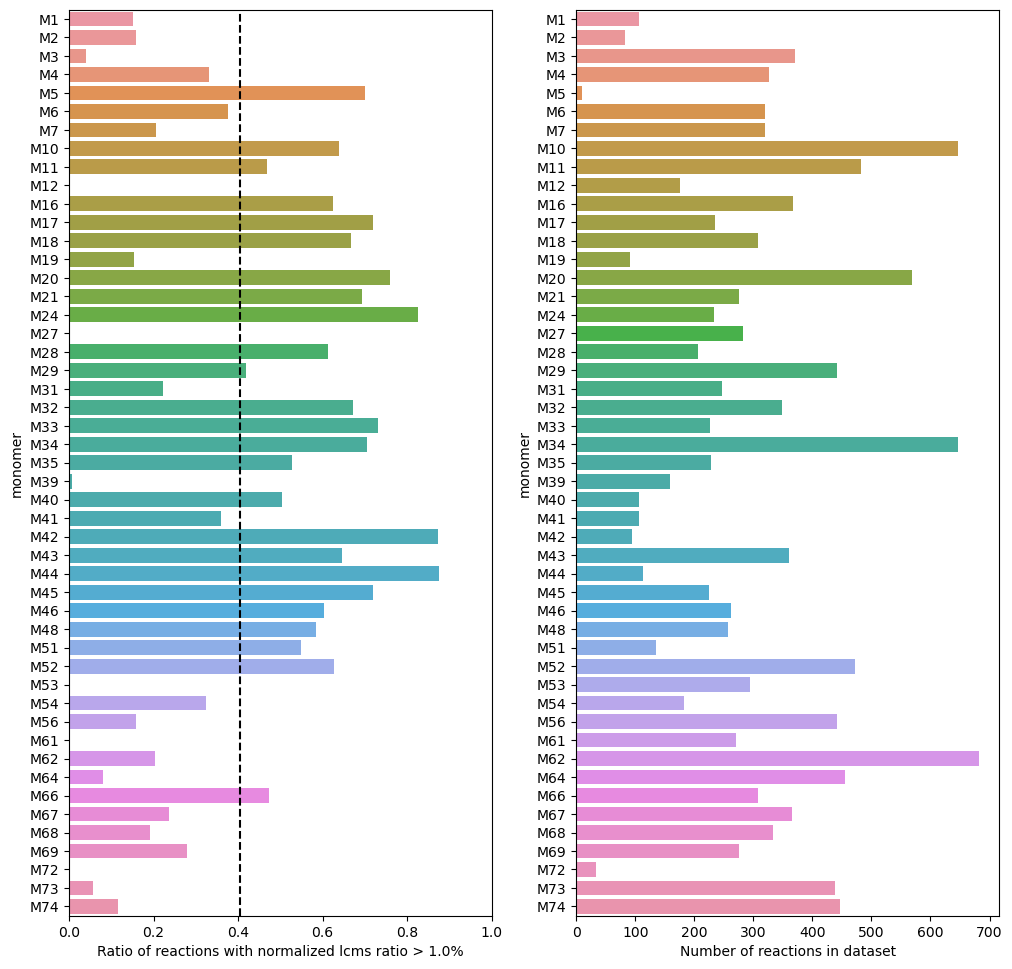

In [33]:
# show how many reactions are successful for each monomer
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

axs[0].axvline(success_rates_by_monomer['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_monomer['success_rate'], y=success_rates_by_monomer['monomer'], ax=axs[0])
sns.barplot(x=success_rates_by_monomer['n_all'], y=success_rates_by_monomer['monomer'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

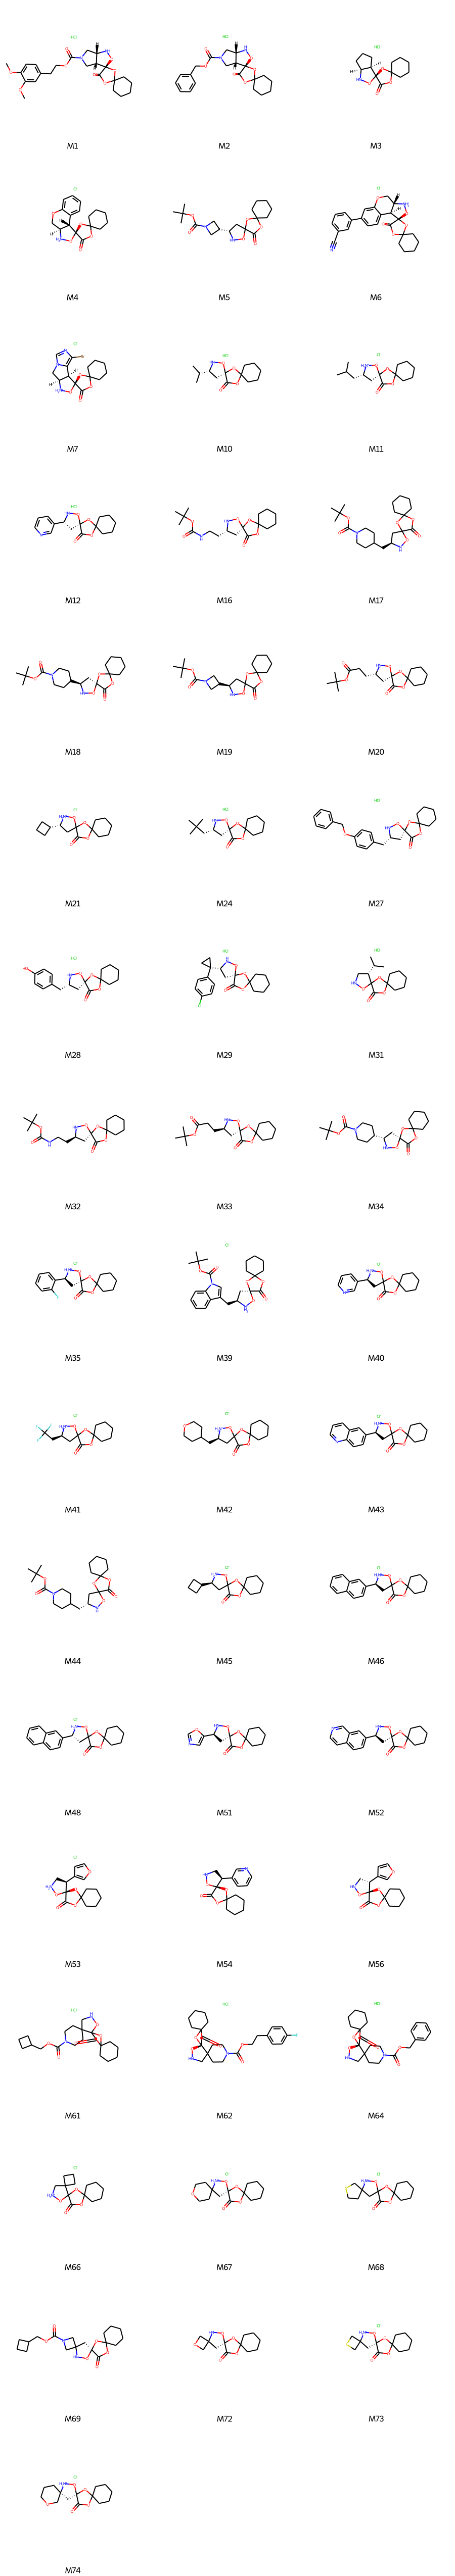

In [35]:
monomer_mols = []
for x in success_rates_by_monomer['monomer']:
    monomer_mols.append(db.get_mol(x))
Draw.MolsToGridImage(monomer_mols, subImgSize=(300, 300), legends=success_rates_by_monomer['monomer'].tolist())

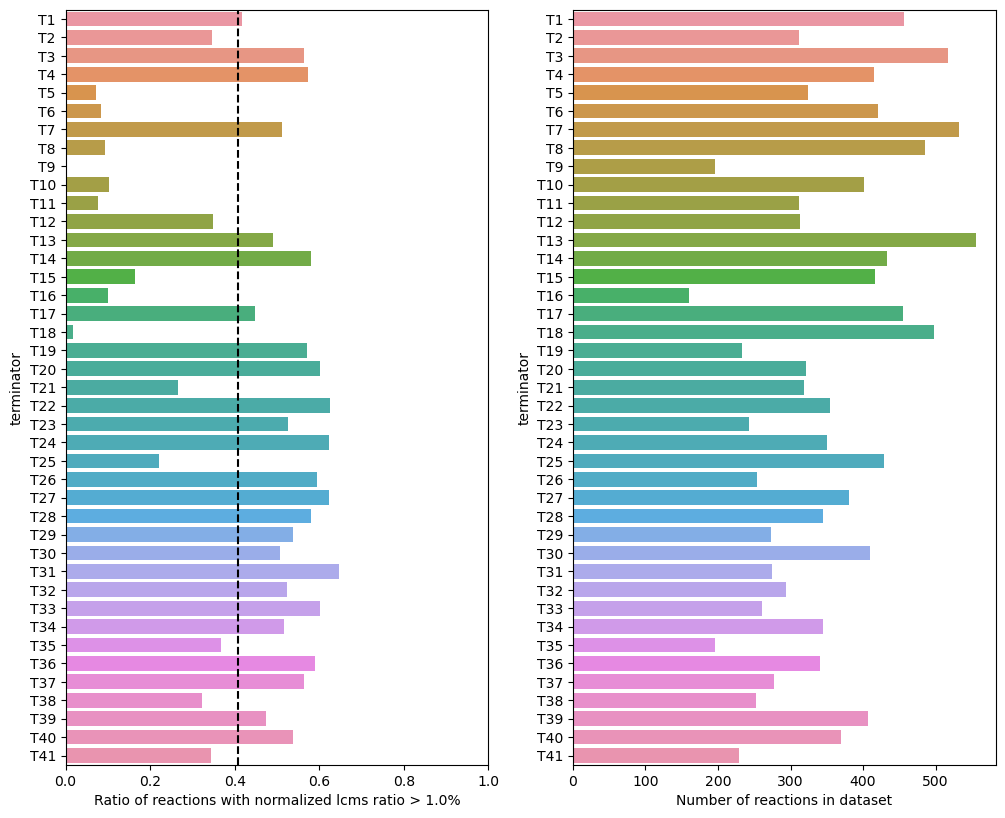

In [36]:
# show how many reactions are successful for each terminator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axs[0].axvline(success_rates_by_terminator['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_terminator['success_rate'], y=success_rates_by_terminator['terminator'], ax=axs[0])
sns.barplot(x=success_rates_by_terminator['n_all'], y=success_rates_by_terminator['terminator'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

### Trends within builing block classes <a id=5></a>
Let's look at how well different types of initiators, monomers, terminators react

In [37]:
# let's check Initiators
success_rates_by_initiator_type = calc_success_rate(df, 'initiator_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_initiator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for KAT_arom: 39.6% (2450/6184)
Success rate for KAT_al: 41.2% (1115/2706)
Success rate for KAT_hetarom: 42.0% (2295/5468)


In [38]:
# let's check Monomers
success_rates_by_monomer_type = calc_success_rate(df, 'monomer_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_monomer_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for Mon_sub_3: 58.5% (4713/8061)
Success rate for Mon_fused: 22.2% (338/1524)
Success rate for Mon_spiro_2: 18.7% (321/1716)
Success rate for Mon_spiro_3: 16.1% (304/1893)
Success rate for Mon_sub_2: 15.8% (184/1164)


In [39]:
# let's check Terminators
success_rates_by_terminator_type = calc_success_rate(df, 'terminator_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_terminator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for TerTH: 51.2% (3663/7158)
Success rate for TerABT: 30.5% (2197/7200)


### Trends controlled for monomer behavior <a id=6></a>
Here we want to look at initiator and terminator success rates only for those monomers that typically work.
For simplicity, we accept only monomers that are have a success ratio of >= 10%

In [40]:
successful_monomers = success_rates_by_monomer.loc[success_rates_by_monomer['success_rate'] >= 0.10, 'monomer']
successful_monomers

0      M1
1      M2
3      M4
4      M5
5      M6
6      M7
7     M10
8     M11
10    M16
11    M17
12    M18
13    M19
14    M20
15    M21
16    M24
18    M28
19    M29
20    M31
21    M32
22    M33
23    M34
24    M35
26    M40
27    M41
28    M42
29    M43
30    M44
31    M45
32    M46
33    M48
34    M51
35    M52
37    M54
38    M56
40    M62
42    M66
43    M67
44    M68
45    M69
48    M74
Name: monomer, dtype: object

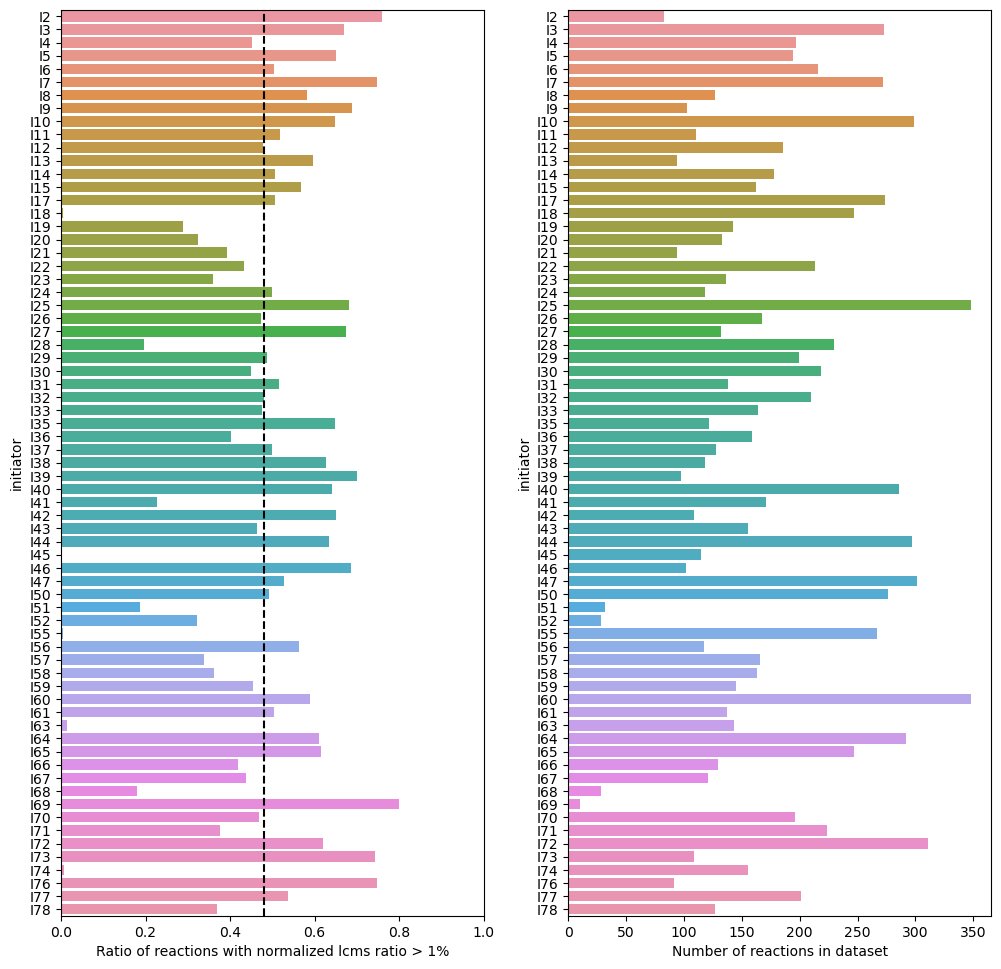

In [41]:
success_rates_by_initiator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 'initiator', THRESHOLD)

# show how many reactions are successful for each initiator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
axs[0].axvline(success_rates_by_initiator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_initiator_for_successful_monomers['success_rate'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[0])
axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.0%}')
axs[0].set_xlim(0,1)

sns.barplot(x=success_rates_by_initiator_for_successful_monomers['n_all'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[1])
axs[1].set_xlabel('Number of reactions in dataset')
plt.show()

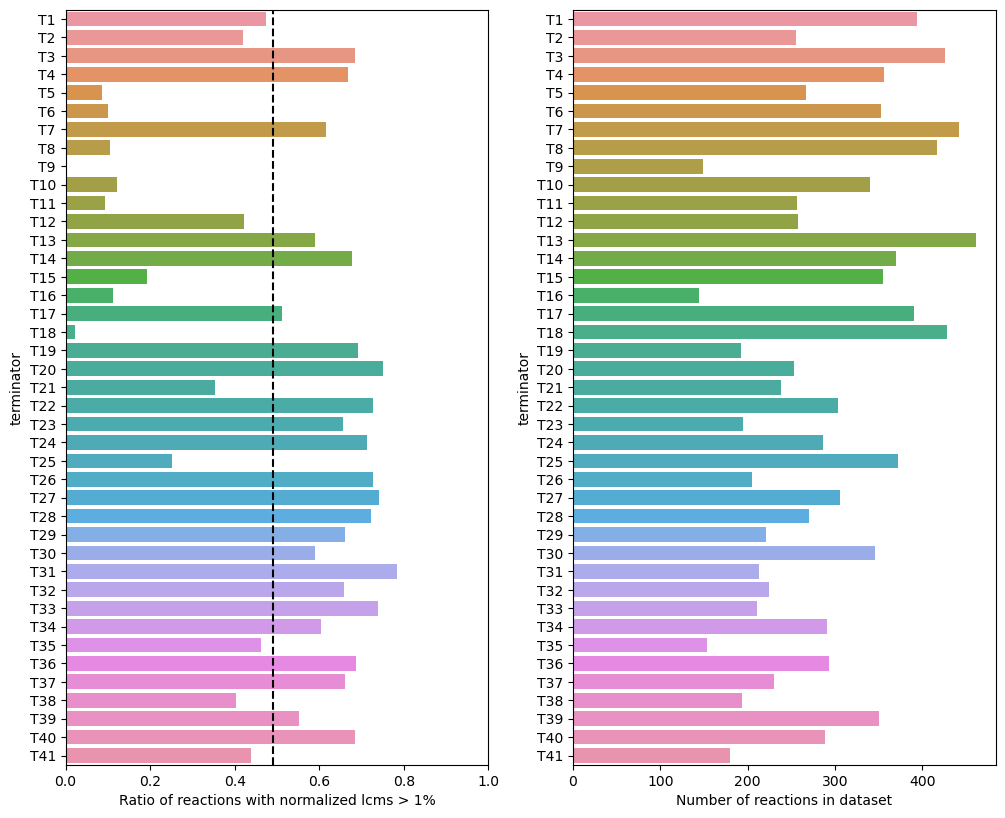

In [42]:
success_rates_by_terminator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 
                                                                        'terminator', 
                                                                        THRESHOLD,
                                                                       )

# show how many reactions are successful for each terminator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
sns.barplot(x=success_rates_by_terminator_for_successful_monomers['success_rate'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[0])
axs[0].axvline(success_rates_by_terminator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
axs[0].set_xlabel(f'Ratio of reactions with normalized lcms > {THRESHOLD:.0%}')
axs[0].set_xlim(0,1)

sns.barplot(x=success_rates_by_terminator_for_successful_monomers['n_all'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[1])
axs[1].set_xlabel('Number of reactions in dataset')
plt.show()

What remains to do?

- Investigate what happens to the monomers where no product A is formed: Do they stall at F/G? Do they not react and we get a lot of D or H instead?

In [43]:
db.show_image('I63')